In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import nltk

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# Load the data, and separate the target
path = "/kaggle/input/nlp-getting-started/train.csv"
dtrain = pd.read_csv(path)
path1 = "/kaggle/input/nlp-getting-started/test.csv"
dtest = pd.read_csv(path1)


df = pd.concat((dtrain, dtest))

**Data Exploration**

In [4]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


In [5]:
## How many are positive (1) and negative (0) in percent:
print(dtrain['target'].mean())

0.4296597924602653


In [6]:
df['keyword'].value_counts()

ablaze                   50
lava                     50
loud%20bang              50
mass%20murder            50
massacre                 50
                         ..
forest%20fire            24
threat                   16
radiation%20emergency    14
inundation               14
epicentre                13
Name: keyword, Length: 221, dtype: int64

In [7]:
print(df['keyword'].isna().sum()/len(df['keyword']))

print(df['location'].isna().sum()/len(df['location']))

0.007999264435454212
0.3344979771974991


In [8]:
df.groupby(['keyword'])['target'].mean()

keyword
ablaze                 0.361111
accident               0.685714
aftershock             0.000000
airplane%20accident    0.857143
ambulance              0.526316
                         ...   
wounded                0.702703
wounds                 0.303030
wreck                  0.189189
wreckage               1.000000
wrecked                0.076923
Name: target, Length: 221, dtype: float64

In [9]:
df['location'].value_counts()

USA                       141
New York                  109
United States              65
London                     58
Canada                     42
                         ... 
Brooklyn                    1
St.Cloud, MN                1
on a catwalk somewhere      1
  å_                        1
Brussels, Belgium           1
Name: location, Length: 4521, dtype: int64

**Feature extraction**

1.) convert to lowercase

In [10]:
df['text'] = (df['text']).str.lower()

2.) Handling location data

In [11]:
df['location'] = df['location'].fillna('None')
df['keyword'] = df['keyword'].fillna('None')

loc = df.location.unique()

Make new list for locations which appear at least 10 times, all other rows will get location 'Unknown'

In [12]:
listt = []
for l in loc:
    if df.location.value_counts()[l] > 9:
        listt.append(l)
        
print(listt)

['None', 'London, UK', 'India', 'USA', 'San Francisco', 'Nashville, TN', 'UK', 'Australia', '304', 'US', 'United States', 'Indonesia', 'Canada', 'San Francisco, CA', 'Toronto', 'Mumbai', 'New York, NY', 'London', 'California, USA', 'Texas', 'New York City', 'Worldwide', 'California', 'Memphis, TN', 'New York', 'Washington, DC', 'Los Angeles, CA', 'Chicago', 'ss', 'Earth', 'Dallas, TX', 'NYC', 'Ireland', 'Los Angeles', 'Denver, CO', 'Philippines', 'World', 'Atlanta, GA', 'Everywhere', 'Nigeria', 'Seattle', 'Florida', 'Calgary, Alberta', 'Seattle, WA', 'Singapore', 'Houston, TX', 'United Kingdom', 'Manchester', 'Chicago, IL', 'Washington, D.C.', 'Denver, Colorado', 'Sacramento, CA', 'Kenya', 'London, England', 'Pennsylvania, USA', 'Colorado', 'Melbourne, Australia', 'Paterson, New Jersey ', ' Road to the Billionaires Club', 'San Diego, CA']


In [13]:
df['location'] = [ll if ll in listt else 'Unknown' for ll in df['location']]

print(df.location.unique())
print(len(df.location.unique()))

['None' 'Unknown' 'London, UK' 'India' 'USA' 'San Francisco'
 'Nashville, TN' 'UK' 'Australia' '304' 'US' 'United States' 'Indonesia'
 'Canada' 'San Francisco, CA' 'Toronto' 'Mumbai' 'New York, NY' 'London'
 'California, USA' 'Texas' 'New York City' 'Worldwide' 'California'
 'Memphis, TN' 'New York' 'Washington, DC' 'Los Angeles, CA' 'Chicago'
 'ss' 'Earth' 'Dallas, TX' 'NYC' 'Ireland' 'Los Angeles' 'Denver, CO'
 'Philippines' 'World' 'Atlanta, GA' 'Everywhere' 'Nigeria' 'Seattle'
 'Florida' 'Calgary, Alberta' 'Seattle, WA' 'Singapore' 'Houston, TX'
 'United Kingdom' 'Manchester' 'Chicago, IL' 'Washington, D.C.'
 'Denver, Colorado' 'Sacramento, CA' 'Kenya' 'London, England'
 'Pennsylvania, USA' 'Colorado' 'Melbourne, Australia'
 'Paterson, New Jersey ' ' Road to the Billionaires Club' 'San Diego, CA']
61


Closer inspection of the locations kept shows that some locations appear multiple times and can be grouped like 'US' with 'USA' or 'New York' and 'New York, NY'

In [14]:
df['location'] = np.where(df['location'].isin(['USA', 'United States']),'US',df['location'])
df['location'] = np.where(df['location'].isin(['United Kingdom']),'UK',df['location'])
df['location'] = np.where(df['location'].isin(['London, UK', 'London, England']),'London',df['location'])
df['location'] = np.where(df['location'].isin(['San Francisco, CA']),'San Francisco',df['location'])
df['location'] = np.where(df['location'].isin(['Washington, D.C.']),'Washington, DC',df['location'])
df['location'] = np.where(df['location'].isin(['Los Angeles, CA']),'Los Angeles',df['location'])
df['location'] = np.where(df['location'].isin(['New York, NY', 'New York City', 'NYC']),'New York',df['location'])
df['location'] = np.where(df['location'].isin(['California, USA']),'California',df['location'])
df['location'] = np.where(df['location'].isin(['Chicago, IL']),'Chicago',df['location'])
df['location'] = np.where(df['location'].isin(['Denver, CO', 'Denver, Colorado']),'Denver',df['location'])
df['location'] = np.where(df['location'].isin(['Seattle, WA']),'Seattle',df['location'])

In [15]:
print(df.groupby(['location'])['target'].mean())

location
 Road to the Billionaires Club    0.166667
304                               0.000000
Atlanta, GA                       0.500000
Australia                         0.500000
Calgary, Alberta                  0.666667
California                        0.468750
Canada                            0.448276
Chicago                           0.448276
Colorado                          0.500000
Dallas, TX                        0.333333
Denver                            0.625000
Earth                             0.727273
Everywhere                        0.200000
Florida                           0.214286
Houston, TX                       0.500000
India                             0.833333
Indonesia                         0.615385
Ireland                           0.500000
Kenya                             0.250000
London                            0.338462
Los Angeles                       0.384615
Manchester                        0.222222
Melbourne, Australia              0.800000
Me

Based on the mean of the target value in the test set the location data seems to be useful

3.) Since both Location and Keyword are categorical features they need to be OneHotEncoded to be useful. This can be done using pd.get_dummies

In [16]:
dummies = pd.get_dummies(df['location'], drop_first=True)
dummies1 = pd.get_dummies(df['keyword'], drop_first=True)

Next we define a function to get the length of a text

In [17]:
def remove_punc(text):
    new = re.sub(r'[^\w\s]', '', text)
    return new

def remove_mentions(text):
    new = re.sub("@\S+", "", text)
    return new

def remove_url(text):
    new = re.sub("https?:\/\/.*[\r\n]*", "", text)
    return new

def remove_hashtag(text):
    new = re.sub("#", "", text)
    return new

def clean_text(text):
    new = remove_url(text)
    new = remove_hashtag(new)
    new = remove_mentions(new)
    new = remove_punc(new)
    return new

def leng(col):
    text = word_tokenize(col, language='english')#word_tokenize
    nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
    filtered = [w for w in text if nonPunct.match(w)]
    return len(filtered)

def char(col):
    #l1=[]
    #for rew in col:
    text = word_tokenize(col, language='english')#word_tokenize
    nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
    filtered = [w for w in text if nonPunct.match(w)]
    #print(text)
    s = [len(u) for u in filtered]
    #l1.append(sum(s))
    return sum(s)

In [18]:
clean_text('#flood #disaster Hello World!!.? @ElonMusk, https://kaggle.com')

'flood disaster Hello World  '

Using this function we can get the word count of a tweet. Furthermore we define a new column with the word count and standartize it afterwards.

In [19]:
df

,id,keyword,location,text,target
0,1,None,None,our deeds are the reason of this #earthquake m...,1.0
1,4,None,None,forest fire near la ronge sask. canada,1.0
2,5,None,None,all residents asked to 'shelter in place' are ...,1.0
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0
4,7,None,None,just got sent this photo from ruby #alaska as ...,1.0
...,...,...,...,...,...
3258,10861,None,None,earthquake safety los angeles ûò safety faste...,NaN
3259,10865,None,None,storm in ri worse than last hurricane. my city...,NaN
3260,10868,None,None,green line derailment in chicago http://t.co/u...,NaN
3261,10874,None,None,meg issues hazardous weather outlook (hwo) htt...,NaN


In [20]:
df['wordCount'] = df['text'].apply(lambda x: leng(x))
dtrain['wordCount'] = dtrain['text'].apply(lambda x: leng(x))

df['charCount'] = df['text'].apply(lambda x: char(x))
dtrain['charCount'] = dtrain['text'].apply(lambda x: char(x))

df['char/wrd'] = df['charCount']/df['wordCount']

wrdcm = dtrain['wordCount'].mean()
wrdcs = dtrain['wordCount'].std()

chm = dtrain['charCount'].mean()
chsd = dtrain['charCount'].std()


print(df[df['target']==1]['char/wrd'].mean())
print(df[df['target']==0]['char/wrd'].mean())

print(df[df['target']==1]['charCount'].mean())
print(df[df['target']==0]['charCount'].mean())

print(df[df['target']==1]['wordCount'].mean())
print(df[df['target']==0]['wordCount'].mean())

#df['wordCount'] = (df['wordCount']-wrdcm)/wrdcs #standartised
#df['charCount'] = (df['charCount']-chm)/chsd

5.852008125478557
5.326301486818918
89.98532558850505
78.27567941040995
15.885661877101803
15.283740211883924


Average word count is very similiar for both disaster and non disaster tweets but disaster tweets have more characters per words on average.

Next apply lemmatization

In [21]:
from nltk.stem import WordNetLemmatizer

wl = WordNetLemmatizer()
 
# single word lemmatization examples
list1 = ['kites', 'babies', 'dogs', 'flying', 'smiling',
         'driving', 'died', 'tried', 'feet']
for words in list1:
    print(words + " ---> " + wl.lemmatize(words))
    
print(wl.lemmatize('hands, birds cars'))

kites ---> kite
babies ---> baby
dogs ---> dog
flying ---> flying
smiling ---> smiling
driving ---> driving
died ---> died
tried ---> tried
feet ---> foot
hands, birds cars


In [22]:
from nltk.corpus import wordnet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [23]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['text'] = df['text'].apply(lambda x: lemmatizer(x))

Next we can add the dummie columns

In [24]:
df = pd.concat((df, dummies), axis=1)
df = pd.concat((df, dummies1), axis=1)

df.head()

,id,keyword,location,text,target,wordCount,charCount,char/wrd,304,"Atlanta, GA",...,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,1,None,None,our deed be the reason of this earthquake may ...,1.0,13,56,4.307692,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,None,None,forest fire near la ronge sask canada,1.0,7,31,4.428571,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,None,None,all resident ask to shelter in place be be not...,1.0,22,110,5.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,None,None,13000 people receive wildfire evacuation order...,1.0,8,56,7.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,None,None,just get send this photo from ruby alaska a sm...,1.0,16,70,4.375000,0,0,...,0,0,0,0,0,0,0,0,0,0


For later use we define the feature columns as all columns other than 'id', 'keyword', 'target', 'text', 'location'

In [25]:
features = df.columns.drop(['id','keyword','target', 'text', 'location'])

4.) Text Vectorization: This will be done using TfidfVectorizer 

In [26]:
stpwrdlist=['the', 'a', 'an']#Custom list of stopwords 
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.001, stop_words=stpwrdlist, ngram_range=(1,3)) #stop_words=stpwrdlist

Split df into train and test set:

In [27]:
train = df[df['target'].notna()]
test =df[df['target'].isna()]
y = train['target']
train = train.drop('target', axis=1)

Fit vectorizer and transform test set

In [28]:
X = vectorizer.fit_transform(train['text'])

X_test = vectorizer.transform(test['text'])

5.) Concatenate features from vectorizer with previous features

In [29]:
X = np.concatenate((X.toarray(), train[features]), axis=1)

X_test = np.concatenate((X_test.toarray(), test[features]), axis=1)

Split train data into train and validation data

In [30]:
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.2, random_state=10)

**Build Neural Network**

In [31]:
from keras.models import Sequential
from keras.layers import Dense
#from keras.callbacks import EarlyStopping

In [32]:
X.shape

(7613, 3376)

In [33]:
model = Sequential()

#early_stopping_monitor = EarlyStopping(patience=1)
model.add(Dense(5, input_shape=(3376,)))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
#model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(1, activation='sigmoid'))

2022-05-26 18:22:38.843291: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 16885     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 18,166
Trainable params: 18,166
Non-trainable params: 0
_________________________________________________________________


In [35]:
opt = tf.keras.optimizers.Adam(0.001) #tf.keras.optimizers.SGD(learning_rate=0.1, momentum=1) 

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
h_callback = model.fit(X_t, y_t, epochs=7, batch_size=50)

2022-05-26 18:22:40.351162: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7
122/122 [==============================] - 1s 3ms/step - loss: 0.6869 - accuracy: 0.5560
Epoch 2/7
122/122 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.5810
Epoch 3/7
122/122 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6673
Epoch 4/7
122/122 [==============================] - 0s 3ms/step - loss: 0.5319 - accuracy: 0.7555
Epoch 5/7
122/122 [==============================] - 0s 3ms/step - loss: 0.4527 - accuracy: 0.8044
Epoch 6/7
122/122 [==============================] - 0s 3ms/step - loss: 0.4014 - accuracy: 0.8314
Epoch 7/7
122/122 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.8425


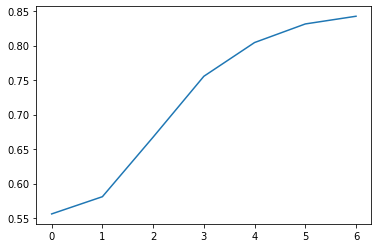

In [37]:
plt.plot( h_callback.history['accuracy'])
#plt.plot( h_callback.history['val_accuracy'])
plt.show()

In [38]:
model.evaluate(X_v, y_v)

48/48 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.8024


[0.4329671561717987, 0.8023637533187866]

The model seems to perform reasonably well. To get a final prediction we will fit it again to the whole testing data

In [39]:
X.shape

(7613, 3376)

In [40]:
model1 = Sequential()

#early_stopping_monitor = EarlyStopping(patience=1)
model1.add(Dense(5, input_shape=(3376,)))
model1.add(Dense(32, activation='sigmoid'))
model1.add(Dense(32, activation='sigmoid'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
model1.fit(X, dtrain['target'], epochs=7, batch_size=50)

Epoch 1/7
153/153 [==============================] - 1s 3ms/step - loss: 0.6790 - accuracy: 0.5707
Epoch 2/7
153/153 [==============================] - 0s 3ms/step - loss: 0.5358 - accuracy: 0.7436
Epoch 3/7
153/153 [==============================] - 0s 3ms/step - loss: 0.4325 - accuracy: 0.8102
Epoch 4/7
153/153 [==============================] - 0s 3ms/step - loss: 0.3885 - accuracy: 0.8342
Epoch 5/7
153/153 [==============================] - 0s 3ms/step - loss: 0.3775 - accuracy: 0.8391
Epoch 6/7
153/153 [==============================] - 0s 3ms/step - loss: 0.3548 - accuracy: 0.8524
Epoch 7/7
153/153 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.8585


In [42]:
pred1 = np.round(model1.predict(X))

In [43]:
pred1

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [44]:
from sklearn.metrics import f1_score, confusion_matrix

print(f1_score(dtrain['target'], pred1))
print(confusion_matrix(dtrain['target'], pred1))

0.8399161695953571
[[4015  327]
 [ 666 2605]]


On the train set the model reaches an accuracy of about 86% and f1_score of about 0.83. However it is trained to overfit slightly as seen from the 0.79 accuracy on the validation set, which is closer to what to expect when applied to the test set.

**Predict and submit**

In [45]:
predictions = np.round(model1.predict(X_test)).astype(int)

In [46]:
sub=pd.DataFrame({'id':dtest['id'].values.tolist(),'target':predictions.ravel()})
sub.to_csv('submission.csv',index=False)

In [47]:
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1
